# Modern Neural Networks - Notebook 2

This notebook will continue on from Notebook 1 of Modern Neural Networks and dive into the OOP-style development of CNN (LeNet-5) with TensorFlow 2.

### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt

## 3 - Building CNNs in TensorFlow:

The CNN introduced here would be the famous LeNet-5 by Yann Le Cun in 1995. This section will cover the process of coding this model.

## 3.1 - LeNet Architecture:

The LeNet-5 model architecture is composed of 7 layers begining with the first layer that is the input layer, where here the input images are zero-padded by 2 resulting in a 32 x 32 output image for the convolutions. The subsequent layers are composed of two blocks that are the convolutional layers, where after each of these layers is a ma-pooling layer. The first convolution layer consists of 6 sets of kernels while the second convolutional layer consist of 16 sets of kernels. After these convolutional layer + max-pooling layers, there are three fully-connected layers that merges the features together until the last layer being the output layer of 10 classes. It should be mentioned that the inputs into the first FC-layers are flatten beforehand.

Additionally, the activations of the convolution and FC layers are now set to ReLU activation functions. The last (output) layer uses a softmax function. The softmax function will normalise the vector values to be between 0 and 1 with the sum = 1. This essentially converts the network's predictions into per-class probabilities.

#### The following diagram shows the model:

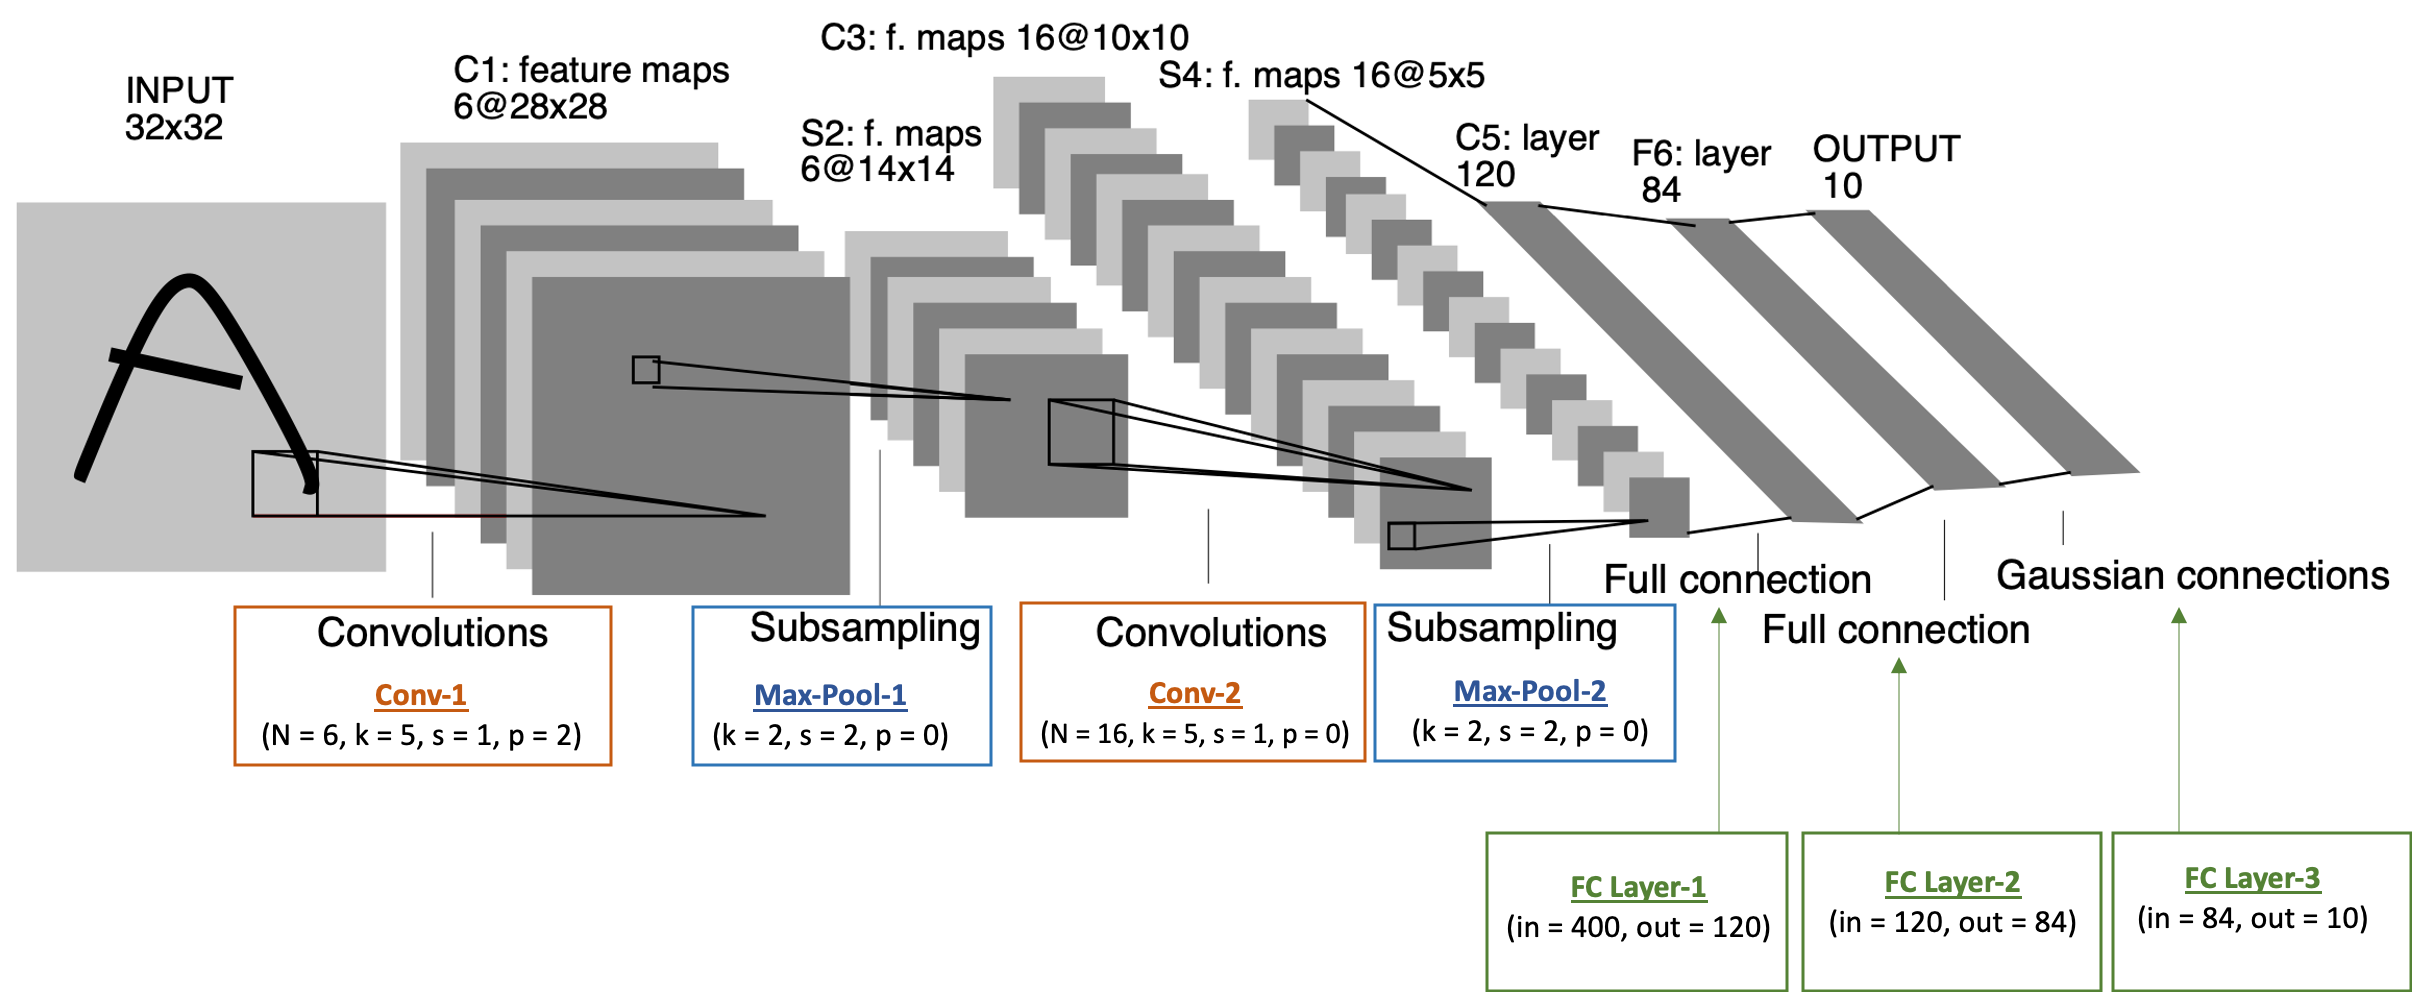

Image ref -> http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf


In [24]:
# LeNet-5 Architecture defined: 
display(Image(image_path + 'LeNet5Architecture.png', width=1000, unconfined=True))
print('Image ref -> http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf')

## 3.2 - TF and Keras Implementations:

### 3.2.1 - Load in the Data:

In [25]:
# Define the number of classes:
nb_classes = 10

# Define the image dimensions:
img_rows, img_cols, img_chnls = 28, 28, 1

# Define the input shape:
input_shape = (img_rows, img_cols, img_chnls)

# Load in the dataset:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

### 3.2.2 - Data Preprocessing:

NOTE: the "*input_shape" where the single " * " notation in the code means a to create a tuple from this argument. where two " * " like " ** " is to create a dictionary.

In [26]:
# Normalise the data:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Inspect:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [27]:
# Reshape the inputs:
x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

# Inspect:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### 3.2.3 - Instantiating the Convolutional Layers:

This section will cover how to wrap the convolution operation into a "Layer" object, here it allows this operation to be more trainable. Further, a bias and an activation function is also required to do this. 

#### A simple Convolutional layer can be defined as the following:

In [28]:
class SimpleConvolutionalLayer(tf.keras.layers.Layer):
    
    def __init__(self, nb_kernels=32, kernel_size=(3, 3), strides=(1, 1), use_bias=True):
        """ This initialises the Conv-Layer.
        Parameters:
            - nb_kernels: Number of Kernels for the convolution operation.
            - kernel_size: Kernel size (H x W)
            - strides: Vertical and horizontal stride defined as a list.
            - use_bias: Flag to add a bias AFTER the convlution or BEFORE the convolution.
        """
        # Call the 'Layer' super __init__() method to initialise the hidden mechanisms:
        super().__init__()
        
        # Assign the parameters:
        self.nb_kernels = nb_kernels
        self.kernel_size = kernel_size
        self.strides = strides
        self.use_bias = use_bias
        
    def build(self, input_shape):
        """ This builds the Layer by initialising the its parameters based on the input shape.
            This func. will be internally called for the first time the layer is used (it can 
            also be called manually).
            
        Parameters:
            - input_shape: Input shape of the layer is (B x H x W x C)
        
        Additional info.:
            - (B x H x W x C) is (batch size x height x width x depth)
        """
        # Define the Input Channels (assumes the shape format to be BHWC):
        nb_input_channels = input_shape[-1]
        
        # Define the shape of the Tensor of the Kernel:
        kernels_shape = (*self.kernel_size, nb_input_channels, self.nb_kernels)
        
        # Initialise the Kernels with values from the Glorot Distribution:
        glorot_uni_initialiser = tf.initializers.GlorotUniform()
        
        # Make the Kernel variable trainable: by using the "add_weights" method.
        self.kernels = self.add_weight(name = 'kernels',
                                      shape = kernels_shape,
                                      initializer = glorot_uni_initialiser,
                                      trainable = True)
        # Add the Bias to make the Kernel variable trainable:
        if self.use_bias:
            self.bias = self.add_weight(name = 'bias',
                                       shape = (self.nb_kernels, ),
                                       initializer = 'random_normal', # Normal distribution.
                                       trainable = True)
    
    def call(self, inputs):
        """ This builds the Call method, to call the layer and perform the operations on the input Tensors.
        Paramters:
            - inputs: Input Tensor
        Returns:
            - returns the Output Tensor
        """
        # Perform the Convolutions:
        z = tf.nn.conv2d(input = inputs, 
                         filters = self.kernels, 
                         strides = [1, *self.strides, 1],
                         padding = "VALID")
        
        # Add the bias upon request:
        if self.use_bias:
            z = z + self.bias
        
        # Apply the Activation Function: ReLu is used.
        return tf.nn.relu(z)
    
    def get_config(self):
        """ This is the Helper Functtion to define the layer and its parameters.
        Returns:
            - returns a Dictionary consisting of the layer's configuration.
        """
        return {'nb_kernels': self.nb_kernels,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'use_bais': self.use_bias}

NOTE: Most of the TF mathematical operations like "tf.maths" and "tf.nn" ould already have their respective derivatives defined in the network. As long as the layer is composed of these operations, there is no need to define the backwards propagation explicitly in code. TF will cover this automatically which saves a lot of time.

#### The Convolutional layer above can now be used inside of a CNN model, like LeNet-5.

NOTE: As a Convolutional is an essential part of CNNs, TF library has already included it as "tf.keras.layers.Conv2D()" class.

For the next section, the Convolutional layer implemented above will be used with other Keras pre-defined layers.

### 3.2.4 - Implementing the LeNet-5 model: with the above "SimpleConvolutionalLayer"

In [29]:
# Import the required libraries:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

#### Build the Model class object: with the above "SimpleConvolutionalLayer"

__NOTE__: that LeNet5(Model) or LeNet5_withTF(Model), where "Model" is from tf.keras.Model and with this sub-classed in the following code blocks, the models will gain/inherit all of its functionalities. This then allows the user to call "model.summary()" tto print out its architecture.

In [30]:
# LeNet-5:
class LeNet5(Model):
    
    def __init__(self, nb_classes):
        """ This builds and initialises the model.
        Parameters:
            - nb_classes, is the number of classes to make a prediction for.
        """
        super(LeNet5, self).__init__()
        
        # Instantiate the layers of the model: 
        self.conv1 = SimpleConvolutionalLayer(nb_kernels = 6,
                                              kernel_size = (5, 5))
        self.conv2 = SimpleConvolutionalLayer(nb_kernels = 16,
                                              kernel_size = (5, 5))
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(units = 120, 
                            activation = 'relu')
        self.dense2 = Dense(units = 84, 
                            activation = 'relu')
        self.dense3 = Dense(units = nb_classes, 
                            activation = 'softmax')
    
    def call(self, inputs):
        """ This builds the Call method, to call the layers and perform its operations on the input Tensors
        Parameters:
            - inputs, is the Input Tensor.
        
        Returns:
            - returns the Output Tensor.
        """
        # 1st Convolution block:
        x = self.max_pool(self.conv1(inputs))
        
        # 2nd Convolution block:
        x = self.max_pool(self.conv2(x))
        
        # Flatten the tensor for the FC-layer:
        x = self.flatten(x)
        
        # Create the FC-layers and return the Output Tensor:
        x = self.dense3(self.dense2(self.dense1(x)))
        
        return x

#### Build the Model class object: uses "tf.keras.layers.Conv2D" instead.

In [31]:
# LeNet-5:
class LeNet5_withTF(Model):
    
    def __init__(self, nb_classes):
        """ This builds and initialises the model.
        Parameters:
            - nb_classes, is the number of classes to make a prediction for.
        """
        super(LeNet5_withTF, self).__init__()
        
        # Instantiate the layers of the model: 
        self.conv1 = Conv2D(filters = 6,
                            kernel_size = (5, 5), 
                            padding='same',
                            activation='relu')
        self.conv2 = Conv2D(filters = 16,
                            kernel_size = (5, 5),
                            activation='relu')
        
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(units = 120, 
                            activation = 'relu')
        self.dense2 = Dense(units = 84, 
                            activation = 'relu')
        self.dense3 = Dense(units = nb_classes, 
                            activation = 'softmax')
    
    def call(self, inputs):
        """ This builds the Call method, to call the layers and perform its operations on the input Tensors
        Parameters:
            - inputs, is the Input Tensor.
        
        Returns:
            - returns the Output Tensor.
        """
        # 1st Convolution block:
        x = self.max_pool(self.conv1(inputs))
        
        # 2nd Convolution block:
        x = self.max_pool(self.conv2(x))
        
        # Flatten the tensor for the FC-layer:
        x = self.flatten(x)
        
        # Create the FC-layers and return the Output Tensor:
        x = self.dense3(self.dense2(self.dense1(x)))
        
        return x

### 3.2.5 - Classifying the MNIST Digits dataset with the implemented CNN model:

This section will instantiate and proceed to compile the LeNet-5 model which will be used for MNIST Digits classification task. 

Before the training process can begin, the optimiser and loss function has to be instantiated first. The optimiser used here will be SGD and the loss function will be categorical cross entropy.

__NOTE__: The Keras' "sparse_categorical_crossentropy" is the same cross-entropy operation as the "categorical_crossentropy" in TF. However, the "sparse_categorical_crossentropy" takes in ground-truth labels as the inputs directly, whereas the "categorical_crossentropy" requires the ground truth to be one-hot encoded beforehand. Therefore, utilising  "sparse_categorical_crossentropy" saves the user from having to transform the labels.

#### Instantiate and Compile the model:

In [ ]:
# Instantiate the model:
model = LeNet5(nb_classes)

# Compile the model:
model.compile(optimizer = 'sgd', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

#### Model Summary:

In [ ]:
# Build the network (automatically) by inferring the input shapes from the samples given to the network:
# Firstly, build the network then use it for prediction.
# _ = model.predict(x_test[:10])

# Building the network (manually): Give the batched input shape to the model.
batched_input_shape = tf.TensorShape( (None, *input_shape) )
print('The batched input shape is: {}'.format(batched_input_shape))

model.build(input_shape = batched_input_shape)

# Print out the Model Architecture:
model.summary()

#### Instantiate the Keras Callbacks:

The Keras Callbacks includes automatically calling the utility functions at specific points during the training process (or before/after the batch training, before/after a full epoch. etc.) to allow for __Monitoring__ the model progression. 

TensorBoard used below allows for the monitoring of the training from Tensorboard. To use this, open a console/terminal to launch the program. Type in "ttensorboard --logdir=./logs". This will then output a browser link where the user can copy and paste it into any browser to see the logs.

In [ ]:
callbacks = [
    # Callback to interrupt the training if the validation loss (`val_loss`) stops improving for over 3 epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    
    # Callback to log the graph, losses and metrics into TensorBoard (saving log files in `./logs` directory):
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)
]

#### Model Training:

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs= 80,
    verbose= 2, # Change to 1 for progress bar. Set to 2 for reduced log size.
    callbacks = callbacks,
    validation_data = (x_test, y_test)
)

#### Conclusion:


#### Model training: with tf.keras.Layers.Conv2D instead.

In [32]:
# Instantiate the model:
model_withTF = LeNet5_withTF(nb_classes)

# Compile the model:
model_withTF.compile(optimizer = 'sgd', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
# Build the network (automatically) by inferring the input shapes from the samples given to the network:
# Firstly, build the network then use it for prediction.
# _ = model.predict(x_test[:10])

# Building the network (manually): Give the batched input shape to the model.
batched_input_shape = tf.TensorShape( (None, *input_shape) )
print('The batched input shape is: {}'.format(batched_input_shape))

model_withTF.build(input_shape = batched_input_shape)

# Print out the Model Architecture:
model_withTF.summary()

In [ ]:
callbacks = [
    # Callback to interrupt the training if the validation loss (`val_loss`) stops improving for over 3 epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    
    # Callback to log the graph, losses and metrics into TensorBoard (saving log files in `./logs` directory):
    tf.keras.callbacks.TensorBoard(log_dir='./logs_tf', histogram_freq=1, write_graph=True)
]

In [ ]:
history_withTF = model_withTF.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs= 80,
    verbose= 2, # Change to 1 for progress bar. Set to 2 for reduced log size.
    callbacks = callbacks,
    validation_data = (x_test, y_test)
)

## 4 - Refining the Training Process:




## Summary:

